In [1]:
# 导入模块
import re

import findspark
from pyspark.sql.types import Row
from pyspark.sql import SparkSession
from pyspark.sql.functions import collect_list

from operator import add

from wordcloud import WordCloud, ImageColorGenerator
import jieba


In [2]:
# ======================== 初始化工作 =========================
# 指明SPARK_HOME
findspark.init("/Users/zhinushannan/environment/spark-3.2.1-bin-hadoop3.2")
# jieba加载自定义字典
jieba.load_userdict("./jieba_dict/dict.txt")
# 新建spark应用
spark = SparkSession.builder.master("local").appName("app").getOrCreate()
sc = spark.sparkContext
# 加载过滤字典
filter_list = []
with open("./jieba_dict/filter_dict.txt") as fp:
    filter_list.extend(fp.read().split("\n"))

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/1q/53p30k9s7x7517km16kh2__00000gn/T/jieba.cache
Loading model cost 0.365 seconds.
Prefix dict has been built successfully.
22/06/06 16:11:56 WARN Utils: Your hostname, zhinushannan-deMacBook-Air.local resolves to a loopback address: 127.0.0.1; using 10.103.4.193 instead (on interface en0)
22/06/06 16:11:56 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/06/06 16:11:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# ============================== 数据清洗 ======================================

In [4]:
def filter_logs(line):
    """
    过滤掉“上传文件”、“成员加入”、“成员离开”三类事件
    :param line:
    :return:
    """
    match_upload = re.search(r"(^\[\S+ \S+]) \[INFO]: 群 (\S+) 内 ([\s\S]+) 上传了文件: ([\s\S]+)", line)
    match_member_add = re.search(r"(^\[\S+ \S+]) \[INFO]: 新成员 (\S+) 进入了群 ([\s\S]+)", line)
    match_member_leave = re.search(r"(^\[\S+ \S+]) \[INFO]: 成员 (\S+) 离开了群 ([\s\S]+)", line)

    if match_upload is None and match_member_add is None and match_member_leave is None:
        return True
    else:
        return False


def map_logs(line):
    """
    将过滤后的日志的发消息和收消息的事件构成新的RDD
    :param line:
    :return:
    """
    match_send = re.search(r"(^\[\S+ \S+]) \[INFO]: 发送群 (\S+) 的消息: ([\s\S]+)", line)
    match_get = re.search(r"(^\[\S+ \S+]) \[INFO]: 收到群 (\S+) 内 ([\s\S]+) 的消息: ([\s\S]+)", line)

    if match_send is None and match_get is None:
        return Row(
            time=None,
            group=None,
            user=None,
            message=line,
        )

    if match_send is not None:
        return Row(
            time=match_send.group(1),
            group=match_send.group(2),
            user="self",
            message=match_send.group(3),
        )
    if match_get is not None:
        return Row(
            time=match_get.group(1),
            group=match_get.group(2),
            user=match_get.group(3),
            message=match_get.group(4),
        )

def flat(l):
    """
    构建新自增列
    :param l:
    :return:
    """
    for k in l:
        if not isinstance(k, (list, tuple)):
            yield k
        else:
            yield from flat(k)

def map_remove_message_some(line):
    """
    移除message中除face以外所有的CQ
    :param line:
    :return:
    """
    message = str(line["_4"])
    # 移除 message_id
    message = message[0:message.rfind("(")]
    # 移除 回复 事件
    result = re.compile(r"(\[CQ:\w+,[\w!@#$%^…￥&()_=+-/*\"'‘’“”,.<>?！？《》、：:|\\]+])").findall(message)
    for i in result:
        if "[CQ:face," in i:
            continue
        message = message.replace(i, "")
    message = message.replace(" ", "")
    return Row(
        time=line["_1"],
        group=line["_2"],
        user=line["_3"],
        message=message
    )


def filter_message(line):
    user = str(line["user"])
    message = str(line["message"])

    return user != "self" and len(message) != 0 and "[CQ:json," not in message

In [23]:
# 读取文件
files = sc.textFile("./logs/2022-05-30.log")

for i in range(0, len(files.collect())):
    print(i, files.collect()[i])

0 [2022-05-30 00:10:02] [INFO]: 收到群 20Z计科通知群(540450397) 内 Q群管家(2854196310) 的消息: [CQ:at,qq=all] 熬夜追剧打游戏，趁机打个健康打卡୧⍤⃝
1 ——来自群管理员（1772203969）的编辑 (878587003) 
2 [2022-05-30 01:06:13] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 e组自提(2730993727) 的消息: 有无出修容（液体哒咩） (489589958) 
3 [2022-05-30 01:06:36] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 e组自提(2730993727) 的消息: 出滋色肤色隔离，还有2/3，12r出 (-1919839913) 
4 [2022-05-30 06:00:02] [INFO]: 收到群 21软件3班通知群(684039593) 内 Q群管家(2854196310) 的消息: [CQ:at,qq=all] 早起的你们打卡没？
5 ——来自群管理员（1648866869）的编辑 (187328788) 
6 [2022-05-30 08:00:06] [INFO]: 收到群 20软件1班官方群(927974093) 内 Q群管家(2854196310) 的消息: [CQ:at,qq=all] 穿过挪威的森林，让我走进你的梦里，夕阳落在我的铠甲，王子不一定骑白马，黑马王子四海为家，现在是早上九点整，我不是马思唯，是催打卡的没人陪，打卡！打卡！打卡！！！
7 ——来自群管理员（2741476253）的编辑 (-1763100933) 
8 [2022-05-30 08:01:29] [INFO]: 收到群 21软件2班(626284843) 内 Q群管家(2854196310) 的消息: [CQ:at,qq=all] 新的一天，新的美好，记得❕❗️健康打卡❗️❕[CQ:image,file=6ddeb3e1383d4b40494abdab142c1f04.image,subType=0]
9 ——来自群管理员（3166230258）的编辑 (1287125274) 
10 [2022-05-30 08:19:46] [INFO]: 收到群 潘安湖

84 尚 ... (511529012) 
85 [2022-05-30 09:32:36] [INFO]: 发送群 20软件3班通知群(953064865) 的消息: 健康打卡自动提醒
86 尚 ... (1905062980) 
87 [2022-05-30 09:32:46] [INFO]: 发送群 科文学院21Z计科(913765781) 的消息: 健康打卡自动提醒
88 尚 ... (1140838867) 
89 [2022-05-30 09:32:57] [INFO]: 发送群 21数据官方群(673433432) 的消息: 健康打卡自动提醒
90 尚 ... (-1207838355) 
91 [2022-05-30 09:33:08] [INFO]: 发送群 21软件2班(626284843) 的消息: 健康打卡自动提醒
92 尚 ... (-1127256722) 
93 [2022-05-30 09:33:19] [INFO]: 发送群 21软件3班通知群(684039593) 的消息: 健康打卡自动提醒
94 尚 ... (-52919980) 
95 [2022-05-30 09:33:24] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 ︶青禾*(2710605724) 的消息: 八成新，裙子都比较重工，质量很好，尺码都是M，鞋子36码黑色，全部30出，             [CQ:image,file=f0cc8cd33378e6737e3b66c2fac7f64b.image][CQ:image,file=7cac1acc7874b73066237b03b3043342.image][CQ:image,file=23cfd400356f3b935af101828dfe35de.image][CQ:image,file=edd7cba2b0539ea30758bb52a0174bfd.image][CQ:image,file=89c54d91aebcc2c1332a7c52bad2e352.image][CQ:image,file=304c8d88440e9c03aa9ccd1f4f7459aa.image][CQ:image,file=9eff33a428af2d954fd18a904f05b19d.im

169 [2022-05-30 11:27:52] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 既出不退(2413544749) 的消息: [CQ:image,file=d256279af17d896b6f0636a06c47dcd7.image,subType=0] (805262953) 
170 [2022-05-30 11:28:50] [INFO]: 收到群 20Z计科通知群(540450397) 内 逯琪    18334883791(1716451970) 的消息: 青年大学习开始了，本周做2022年第14期，按照上周的格式，以宿舍为单位上交，截图于今晚8：00前上交，辛苦大家配合一下按时上交，谢谢！@全体成员  (-5859674) 
171 [2022-05-30 11:28:53] [INFO]: 收到群 18软件2班在线群(780548179) 内 孙仪鹏(1120983676) 的消息: 孙仪鹏生源地信息已核对，无误 (-1612125925) 
172 [2022-05-30 11:30:08] [INFO]: 收到群 18软件2班在线群(780548179) 内 Q群管家(2854196310) 的消息: [CQ:at,qq=all] 还有人没打卡，快看看是不是你😱😱😱「江苏师范大学科文学院信息工程系18软件2班宣」
173 ——来自群管理员（2732160776）的编辑 (115456161) 
174 [2022-05-30 11:32:03] [INFO]: 发送群 18软件2班在线群(780548179) 的消息: 健康打卡自动提醒
175 尚 ... (1910933559) 
176 [2022-05-30 11:32:14] [INFO]: 发送群 20Z计科通知群(540450397) 的消息: 健康打卡自动提醒
177 尚 ... (-2002672080) 
178 [2022-05-30 11:32:21] [INFO]: 收到群 20软件2班官方群(953152455) 内 健康打卡小助手(3528275423) 的消息: 健康打卡自动提醒
179 尚未打卡的同学如下：
180 [CQ:at,qq=840066450] 	[CQ:at,qq=421712537] 	[CQ:at,qq=2

211 [2022-05-30 11:55:22] [INFO]: 收到群 21数据官方群(673433432) 内 魏乐翔(50830046) 的消息: [CQ:image,file=ee8f8bef1fd6eaac222f3ab470e82613.image,subType=0] (1215909145) 
212 [2022-05-30 11:55:38] [INFO]: 收到群 21数据官方群(673433432) 内 魏乐翔(50830046) 的消息: 今日核酸名单，地点是教1楼与教2楼连廊，入口在教2楼东侧。[CQ:face,id=63] (1065254287) 
213 [2022-05-30 11:56:46] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 代拿代买代写代课（期末闭关不接单）(3176627878) 的消息: 出，就用过一次，嘎嘎亮，宿舍小太阳，唯一的缺点就是胶不大粘，自己补点胶就好，10r出[CQ:image,file=c3835fd03805ca7112ed316626bc76d3.image][CQ:image,file=5fcebba93f71136449417e19212abbcd.image] (-1996966015) 
214 [2022-05-30 11:57:51] [INFO]: 收到群 21数据官方群(673433432) 内 魏乐翔(50830046) 的消息: [CQ:json,data={"app":"com.tencent.structmsg"&#44;"config":{"ctime":1653883071&#44;"forward":true&#44;"token":"18e9a934277dc131f3c6151f9883ef25"&#44;"type":"normal"}&#44;"desc":"新闻"&#44;"extra":{"app_type":1&#44;"appid":101458937&#44;"uin":50830046}&#44;"meta":{"news":{"action":""&#44;"android_pkg_name":""&#44;"app_type":1&#44;"appid":101458937&#44;"ctime":1653883

282 [2022-05-30 13:19:44] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 ``(418519293) 的消息: [CQ:image,file=89c205bfdd6a0a04e15f7c7fef933c4d.image,subType=0] (-724380460) 
283 [2022-05-30 13:19:45] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 ``(418519293) 的消息: [CQ:image,file=b82418315258cbbd4f761a84c3b2f6b1.image,subType=0] (-1546263486) 
284 [2022-05-30 13:19:46] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 ``(418519293) 的消息: [CQ:image,file=773bc9514d6875fe7144369b834ea8ab.image,subType=0] (987543032) 
285 [2022-05-30 13:19:46] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 ``(418519293) 的消息: [CQ:image,file=d0a59d9ccab0f0bf744c503d248076e1.image,subType=0] (1306232174) 
286 [2022-05-30 13:19:50] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 ``(418519293) 的消息: 服装店不干了，全部特价、 (-742453043) 
287 [2022-05-30 13:20:55] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 出租麻将耶(2089325471) 的消息: 这算打广告吗 (-1531436965) 
288 [2022-05-30 13:21:02] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 出租麻将耶(2089325471) 的消息: 我收电竞椅被刷上去了 (1035039201) 
289 [2022-05-30 13:22:10] [INFO]: 收

353 [2022-05-30 14:25:24] [INFO]: 收到群 21软件3班通知群(684039593) 内 宋杰鹏(417196977) 的消息: 带电脑 (1656493303) 
354 [2022-05-30 14:25:35] [INFO]: 收到群 20软件2班官方群(953152455) 内 张彦伟195 5163 5017(1458335158) 的消息: 本学期公共课考试时间已出，考场安排等待通知。请同学做好迎考准备，同时提醒重修、补修的学生，相关考试跟班进行。@全体成员 (-45729638) 
355 [2022-05-30 14:25:46] [INFO]: 群 20软件2班官方群(953152455) 内 张彦伟195 5163 5017(1458335158) 上传了文件: 附件1：2022年春季学期部分公共课期末考试安排表.doc 
356 [2022-05-30 14:28:15] [INFO]: 新成员 川上赴野(2564717947) 进入了群 潘安湖二手物品转卖群(949682820). 
357 [2022-05-30 14:29:44] [INFO]: 收到群 21软件2班(626284843) 内 王明玮(2990317540) 的消息: 本学期公共课考试时间已出，考场安排等待通知。请同学做好迎考准备，同时请重修、补修的学生，相关考试跟班进行。@全体成员 (-861562399) 
358 [2022-05-30 14:29:53] [INFO]: 群 21软件2班(626284843) 内 王明玮(2990317540) 上传了文件: 附件1：2022年春季学期部分公共课期末考试安排表.doc 
359 [2022-05-30 14:31:01] [INFO]: 收到群 新蜂生活超市(854452883) 内 新蜂生活超市(105070597) 的消息: 宏宝莱的没货啊，我再问问 (39571581) 
360 [2022-05-30 14:35:11] [INFO]: 收到群 实干青年 - 老年人活动(369746384) 内 张浩健(1427774041) 的消息: 卧槽 (-1524894237) 
361 [2022-05-30 14:35:19] [INFO]: 收到群 实干青年 - 老年人活动(3

425 [2022-05-30 15:45:44] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 帅哥1号(2268551581) 的消息: 正常死只猫不会查 (1691616305) 
426 [2022-05-30 15:45:47] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 b组 代抄 代拿 代买 (2889626979) 的消息: 不查？ (-194307680) 
427 [2022-05-30 15:45:52] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 abcd打印（不接了勿扰）(1024664153) 的消息: 可是这个太恶劣了 (-2090063562) 
428 [2022-05-30 15:45:55] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 abcd打印（不接了勿扰）(1024664153) 的消息: 又不是自然死亡 (-475291437) 
429 [2022-05-30 15:45:56] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 帅哥1号(2268551581) 的消息: 这他妈直接肢解了 (-1800630203) 
430 [2022-05-30 15:45:58] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 abcd打印（不接了勿扰）(1024664153) 的消息: 对啊 (228966911) 
431 [2022-05-30 15:45:59] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 abcd打印（不接了勿扰）(1024664153) 的消息: 我靠 (2057498985) 
432 [2022-05-30 15:46:06] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 陆净(1925800532) 的消息: 心理变态吧 (-456760118) 
433 [2022-05-30 15:46:06] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 abcd打印（不接了勿扰）(1024664153) 的消息: 今天肢解的猫 (-1816046500) 
434 [20

510 [2022-05-30 15:49:45] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 少时月白(1226102551) 的消息: 女生应该抓不到的吧 (728902363) 
511 [2022-05-30 15:49:47] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 我爱物理我爱物理，我真的很爱物理(1297492943) 的消息: ？ (1551178317) 
512 [2022-05-30 15:49:49] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 b自取(2504715167) 的消息: c是男生啊 (-981709833) 
513 [2022-05-30 15:49:53] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 万(3302817190) 的消息: ？ (-1300530335) 
514 [2022-05-30 15:49:54] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 少时月白(1226102551) 的消息: [CQ:reply,id=-981709833][CQ:at,qq=2504715167] [CQ:at,qq=2504715167] D (740290242) 
515 [2022-05-30 15:49:54] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 被窝哲学家(1911942876) 的消息: c是女生 (1528356436) 
516 [2022-05-30 15:49:55] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 我爱物理我爱物理，我真的很爱物理(1297492943) 的消息: ？ (-1039036434) 
517 [2022-05-30 15:49:56] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 少时月白(1226102551) 的消息: 别乱说 (-1256800392) 
518 [2022-05-30 15:49:56] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 b组 代抄 代拿 代买 (2889626979) 的消息: c

590 [2022-05-30 15:52:57] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 emo怪(1326768287) 的消息: 可能真的心理变态 (-1271698078) 
591 [2022-05-30 15:53:04] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 我爱物理我爱物理，我真的很爱物理(1297492943) 的消息: 我们这里潜藏一个 (-1019978252) 
592 [2022-05-30 15:53:08] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 我爱物理我爱物理，我真的很爱物理(1297492943) 的消息: 危险分子 (1513950286) 
593 [2022-05-30 15:53:14] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 虾饺(1094184054) 的消息: 雀氏 (758791384) 
594 [2022-05-30 15:53:23] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 一粒暗淡星.(3169862712) 的消息: 不是好人 (-1285641861) 
595 [2022-05-30 15:53:24] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 帅哥1号(2268551581) 的消息: 我下楼了 (-1000760851) 
596 [2022-05-30 15:53:31] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 一粒暗淡星.(3169862712) 的消息: 我也 (1565575255) 
597 [2022-05-30 15:53:41] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 emo怪(1326768287) 的消息: [CQ:reply,id=1145829654][CQ:at,qq=1094184054] 也不能这么说，变态不分性别 (710408385) 
598 [2022-05-30 15:54:11] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 日常恶周期(508225953) 的消息: 不管男女 

667 [2022-05-30 16:07:37] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 筱二不爱挂科(3084001365) 的消息: 都分散尸体了 (-1707784991) 
668 [2022-05-30 16:07:39] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 筱二不爱挂科(3084001365) 的消息: ？ (-315460489) 
669 [2022-05-30 16:07:41] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 暮色陈陈(2149601762) 的消息: 大概这里 (1950033357) 
670 [2022-05-30 16:07:54] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 虾饺(1094184054) 的消息: 好像猫头也不是不可能那么正/汪汪 (54269275) 
671 [2022-05-30 16:07:57] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 暮色陈陈(2149601762) 的消息: 这是b组团的视角 (-1820129078) 
672 [2022-05-30 16:08:00] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 虾饺(1094184054) 的消息: 在地上 (-461096868) 
673 [2022-05-30 16:08:04] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 暮色陈陈(2149601762) 的消息: 而且刚好在路边 (-2075938375) 
674 [2022-05-30 16:08:13] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 一粒暗淡星.(3169862712) 的消息: 太正了 (-213614289) 
675 [2022-05-30 16:08:14] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 暮色陈陈(2149601762) 的消息: 树子边 (1783484565) 
676 [2022-05-30 16:08:24] [INFO]: 收到群 潘安湖二手物品转卖群(949682

747 [2022-05-30 16:23:01] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 伊人莫相忘(2940409154) 的消息: [CQ:reply,id=-164780039][CQ:at,qq=1203187883] [CQ:at,qq=1203187883] 不知道更可怕吧 (266567590) 
748 [2022-05-30 16:23:05] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 私貘(2718554774) 的消息: 让他被开除！！ (2028228400) 
749 [2022-05-30 16:23:10] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 章鱼🐙小丸子(2326124006) 的消息: 这种人也没有必要帮他遮遮掩掩 (-427763053) 
750 [2022-05-30 16:23:12] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 伊人莫相忘(2940409154) 的消息: 无法防范 (-1853363707) 
751 [2022-05-30 16:23:12] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 章鱼🐙小丸子(2326124006) 的消息: 对！ (143571903) 
752 [2022-05-30 16:23:13] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 🍓(2441186869) 的消息: 心理指定有问题 (2139720489) 
753 [2022-05-30 16:23:14] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 私貘(2718554774) 的消息: 档案留污点！ (-281635144) 
754 [2022-05-30 16:23:19] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 私貘(2718554774) 的消息: 留案底！ (-1741576658) 
755 [2022-05-30 16:23:20] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 章鱼🐙小丸子(2326124006) 的消息: 真的是心理有

820 [2022-05-30 16:29:36] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 暮色陈陈(2149601762) 的消息: 居然有那么多奇葩 (1078284620) 
821 [2022-05-30 16:29:36] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 A代刷网课 出脚本 期末线上题库 猴博士全套(851949205) 的消息: 去年和今年手法一致，总有被逮到的那天 (-649330442) 
822 [2022-05-30 16:29:38] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 章鱼🐙小丸子(2326124006) 的消息: 这种事情 (-1370804128) 
823 [2022-05-30 16:29:42] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 章鱼🐙小丸子(2326124006) 的消息: 不应该严查吗？ (1056189937) 
824 [2022-05-30 16:30:18] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 章鱼🐙小丸子(2326124006) 的消息: 这种胆大包天的事情，对其他学生造成身心健康影响的事情，应该严查的 (1240669543) 
825 [2022-05-30 16:31:07] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 A代刷网课 出脚本 期末线上题库 猴博士全套(851949205) 的消息: 可以去向驻警反应，管不管不知道了 (691311746) 
826 [2022-05-30 16:31:39] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 肉肉(3270682323) 的消息: 不是说已经查监控了嘛 (1580442644) 
827 [2022-05-30 16:32:20] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 A代刷网课 出脚本 期末线上题库 猴博士全套(851949205) 的消息: 消息太多了没翻过来，如果是查了就有希望 (-952437330) 
828 [2022-05-30 16:37:26] [INFO]: 收到群 潘

890 [2022-05-30 16:49:09] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 Shotaro Hidari(2055728505) 的消息: 猫咪埋了吧 (-103109595) 
891 [2022-05-30 16:49:10] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 代买代写代拿快递(3357117106) 的消息: 我宿舍里五十包纸用不上[CQ:face,id=64] (1624505759) 
892 [2022-05-30 16:49:20] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 代买代写代拿快递(3357117106) 的消息: [CQ:face,id=5][CQ:face,id=5] (399822089) 
893 [2022-05-30 16:49:55] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 伊人莫相忘(2940409154) 的消息: 教四318 (-1984931670) 
894 [2022-05-30 16:50:01] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 伊人莫相忘(2940409154) 的消息: 有字 (-21534660) 
895 [2022-05-30 16:50:08] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 伊人莫相忘(2940409154) 的消息: 抽纸 (1740519814) 
896 [2022-05-30 16:50:10] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 代拿代买代写代课（期末闭关不接单）(3176627878) 的消息: [CQ:image,file=08747db4883e018d830ede045398082c.image,subType=1] (280561936) 
897 [2022-05-30 16:50:13] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 代拿代买代写代课（期末闭关不接单）(3176627878) 的消息: 嘎嘎嘎嘎嘎 (-2147085183) 
898 [2022-05-30 16:50:25]

962 明日核酸，少数有课的班级可以调整核酸时间：10:15—11:00，12:00—15:00，其他仍需按照规定时间前往核酸点，地点是教1楼与教2楼连廊，入口在教2楼东侧。[CQ:at,qq=all] (265957588) 
963 [2022-05-30 17:27:38] [INFO]: 收到群 科文学院21Z计科(913765781) 内 班主任(313323736) 的消息: 明日核酸，少数有课的班级可以调整核酸时间：10:15—11:00，12:00—15:00，其他仍需按照规定时间前往核酸点，地点是教1楼与教2楼连廊，入口在教2楼东侧。[CQ:at,qq=all] 
964 [CQ:image,file=61d0682dd6b160effba306ac774caeaa.image,subType=0] (-1888833769) 
965 [2022-05-30 17:27:50] [INFO]: 收到群 18软件2班在线群(780548179) 内 盛老师(511754133) 的消息: [CQ:image,file=160bd7ef2b7a1fb77b7ef61e2473ec00.image,subType=0] (1988840494) 
966 [2022-05-30 17:28:43] [INFO]: 收到群 新蜂生活超市(854452883) 内 陆逊(80000000) 的消息: 超市面包有活动吗 (472720677) 
967 [2022-05-30 17:28:58] [INFO]: 收到群 18软件2班在线群(780548179) 内 盛老师(511754133) 的消息: 各位同学：
968     档案派遣已完成初步修改审核，现上传文件，请大家二次核对，如有问题请于今晚20:00前反馈，后续将不予更改，再次提醒，档案派遣大家一定要仔细核对哈，拿不准的最好能打电话咨询接收单位，确认好是否可以接收，如因修改错误，也将导致派遣错误，造成档案丢失。[CQ:at,qq=all] (-432778817) 
969 [2022-05-30 17:30:11] [INFO]: 收到群 18软件2班在线群(780548179) 内 盛老师(511754133) 的消息: 上海诺行信息技术有限公司2022届春招补录发车！冲！还有机会！
970

1064 [2022-05-30 18:47:38] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 既出不退(2413544749) 的消息: [CQ:image,file=e848ce1c7907852a52be7d6656a7b02d.image,subType=0] (927674414) 
1065 [2022-05-30 18:50:57] [INFO]: 收到群 20Z计科通知群(540450397) 内 辅导员——王群(953060053) 的消息: [CQ:at,qq=728514179] [CQ:at,qq=1329192685] [CQ:at,qq=473591485] [CQ:at,qq=819184328] 乡村振兴计划面试通知安排已发，明天就面试了，收到回复一下，不然我还要打电话一一通知 (932750467) 
1066 [2022-05-30 18:51:27] [INFO]: 收到群 20Z计科通知群(540450397) 内 刘东琪 13182382727(1329192685) 的消息: 收到 (-1366166215) 
1067 [2022-05-30 18:56:45] [INFO]: 收到群 20Z计科通知群(540450397) 内 45王欢欢15150816773(819184328) 的消息: 收到 (-644430417) 
1068 [2022-05-30 18:59:09] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 焦糖玛奇朵(3435533851) 的消息: 出[CQ:image,file=41de55c22147cc6f55a378b5ee539092.image,subType=0] (1078722744) 
1069 [2022-05-30 19:01:21] [INFO]: 收到群 20Z计科通知群(540450397) 内 辅导员——王群(953060053) 的消息: 毕业季，群内通知都很重要，也很紧急，请各位同学务必及时关注群消息，不看，看了不回会增加老师很大的工作量。自己的事情自己要上心，马上要走上社会了，社会人没有那么多人迁就大家，或者一再给大家补救机会。请大家换位思考[CQ:at,qq=all]  (1227479102) 
107

1134 [2022-05-30 20:07:57] [INFO]: 收到群 新蜂生活超市(854452883) 内 诸葛瑾(80000000) 的消息: 两边都是女生宿舍，哪个男的敢去？ (-485617726) 
1135 [2022-05-30 20:08:12] [INFO]: 收到群 新蜂生活超市(854452883) 内 温情.(2268551581) 的消息: ab中间 (-1811333292) 
1136 [2022-05-30 20:08:20] [INFO]: 收到群 新蜂生活超市(854452883) 内 傅彤(80000000) 的消息: 男的有恐女症？ (218132206) 
1137 [2022-05-30 20:08:20] [INFO]: 收到群 新蜂生活超市(854452883) 内 温情.(2268551581) 的消息: 为啥不能去 (2047303288) 
1138 [2022-05-30 20:08:23] [INFO]: 收到群 新蜂生活超市(854452883) 内 温情.(2268551581) 的消息: ？？ (-463221797) 
1139 [2022-05-30 20:08:26] [INFO]: 收到群 新蜂生活超市(854452883) 内 小po(2297728680) 的消息: 为啥不敢去啊 (-1822098611) 
1140 [2022-05-30 20:08:29] [INFO]: 收到群 新蜂生活超市(854452883) 内 温情.(2268551581) 的消息: 那边本来就散步的 (174959351) 
1141 [2022-05-30 20:08:31] [INFO]: 收到群 新蜂生活超市(854452883) 内 傅彤(80000000) 的消息: 不是很能理解 (2104138337) 
1142 [2022-05-30 20:08:37] [INFO]: 收到群 新蜂生活超市(854452883) 内 小po(2297728680) 的消息: 那边还有篮球场啊 (-304773136) 
1143 [2022-05-30 20:08:49] [INFO]: 收到群 新蜂生活超市(854452883) 内 小po(2297728680) 的消息: 正常都是走那条路过的 

1206 [2022-05-30 20:51:14] [INFO]: 收到群 新蜂生活超市(854452883) 内 耿纪(80000000) 的消息: 白猫 (127341072) 
1207 [2022-05-30 20:51:17] [INFO]: 收到群 新蜂生活超市(854452883) 内 小po(2297728680) 的消息: 然后说是生病的 (1888494214) 
1208 [2022-05-30 20:51:28] [INFO]: 收到群 新蜂生活超市(854452883) 内 小po(2297728680) 的消息: 我搞不懂，怎么生病就肠子就翻出来了 (-375819460) 
1209 [2022-05-30 20:51:42] [INFO]: 收到群 新蜂生活超市(854452883) 内 小po(2297728680) 的消息: [CQ:image,file=dce0f930cfbfa4f25363e1b03f0978af.image,subType=1] (-1633795158) 
1210 [2022-05-30 20:51:54] [INFO]: 收到群 新蜂生活超市(854452883) 内 小po(2297728680) 的消息: 从那时候开始我就觉得学校里有人虐猫 (237067835) 
1211 [2022-05-30 20:52:01] [INFO]: 收到群 新蜂生活超市(854452883) 内 耿纪(80000000) 的消息: 对 (2032561837) 
1212 [2022-05-30 20:52:08] [INFO]: 收到群 新蜂生活超市(854452883) 内 耿纪(80000000) 的消息: 有人说是车压的 (434235208) 
1213 [2022-05-30 20:52:17] [INFO]: 收到群 新蜂生活超市(854452883) 内 当 当 当 duang duang duang(1043618032) 的消息: 应该是车压的 (1860622302) 
1214 [2022-05-30 20:52:17] [INFO]: 收到群 新蜂生活超市(854452883) 内 耿纪(80000000) 的消息: 可是车压了的猫不应该是那样的 (-135297436) 
1215

1276 [2022-05-30 21:23:35] [INFO]: 收到群 新蜂生活超市(854452883) 内 司马朗(80000000) 的消息: 好!我明天再去买🥰🥰 (-1554613504) 
1277 [2022-05-30 21:24:40] [INFO]: 收到群 新蜂生活超市(854452883) 内 Glimmering.AN(2677477571) 的消息: [CQ:image,file=8c705353712e602d478a028287b2bff5.image,subType=0] (-732869738) 
1278 [2022-05-30 21:24:54] [INFO]: 收到群 新蜂生活超市(854452883) 内 Glimmering.AN(2677477571) 的消息: 任何一个人不喜欢吃鸭脖我都会难过的 (-1265188237) 
1279 [2022-05-30 21:25:09] [INFO]: 收到群 新蜂生活超市(854452883) 内 新蜂生活超市(105070597) 的消息: 少了一个 (-1013845275) 
1280 [2022-05-30 21:26:43] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 暮色陈陈(2149601762) 的消息: d个打印 (1297154162) 
1281 [2022-05-30 21:26:44] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 A代刷网课 出脚本 期末线上题库 猴博士全套(851949205) 的消息: [CQ:image,file=1375037e6610e37015c69d9c9eff7af7.image,subType=0] (978727140) 
1282 [2022-05-30 21:26:46] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 安稳(804565591) 的消息: [CQ:image,file=4cd656356bc98d52b987d314ba3bd5ff.image,subType=1] (-1427559051) 
1283 [2022-05-30 21:26:47] [INFO]: 收到群 潘安湖二手物品转卖群(949682

1345 [2022-05-30 22:10:44] [INFO]: 收到群 20Z计科通知群(540450397) 内 潜艺筝 17712117344(1772203969) 的消息: 是群文件 (-1666738245) 
1346 [2022-05-30 22:10:45] [INFO]: 收到群 20Z计科通知群(540450397) 内 刘奕辰 18864123362(2777075784) 的消息: 明天了应该 (-341792979) 
1347 [2022-05-30 22:10:45] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 出租麻将耶(2089325471) 的消息: 想要那样的，嗯， (879362299) 
1348 [2022-05-30 22:10:46] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 出租麻将耶(2089325471) 的消息: [CQ:image,file=4c1c5d469df3317c7d21e974fbb761fc.image,subType=1] (1131229293) 
1349 [2022-05-30 22:10:58] [INFO]: 收到群 20Z计科通知群(540450397) 内 潜艺筝 17712117344(1772203969) 的消息: 智慧团建吗？我刚进去过 (2065676988) 
1350 [2022-05-30 22:11:09] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 c自取(3075906053) 的消息: 宿舍的也不能给吧，毕业要查的好像 (598391176) 
1351 [2022-05-30 22:11:14] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 c自取(3075906053) 的消息: [CQ:image,file=33fee6f8cd031dd6a5ac9191afe748da.image,subType=1] (1420658974) 
1352 [2022-05-30 22:12:40] [INFO]: 收到群 20Z计科通知群(540450397) 内 孙畅  17768289561(473591485) 的消息: 这是干什么的？ (

1404 [2022-05-30 22:47:43] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
1405 [2022-05-30 22:47:45] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 b组团(2465397940) 的消息: 非常爽 (1517682988) 
1406 [2022-05-30 22:47:46] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
1407 [2022-05-30 22:47:46] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
1408 [2022-05-30 22:47:49] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
1409 [2022-05-30 22:47:49] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
1410 [2022-05-30 22:47:52] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
1411 [2022-05-30 22:47:52] [WARNING]: 连接到反向WebSocket Universal服务器 ws:/

1472 [2022-05-30 22:49:25] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
1473 [2022-05-30 22:49:25] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
1474 [2022-05-30 22:49:28] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
1475 [2022-05-30 22:49:28] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
1476 [2022-05-30 22:49:31] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
1477 [2022-05-30 22:49:31] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
1478 [2022-05-30 22:49:34] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
1479 [2022-05-30 22:49:34] [WARNING]: 连接到反向WebSocket Universal服务器

1532 [2022-05-30 22:50:55] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
1533 [2022-05-30 22:50:55] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
1534 [2022-05-30 22:50:58] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
1535 [2022-05-30 22:50:58] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
1536 [2022-05-30 22:51:01] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
1537 [2022-05-30 22:51:01] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
1538 [2022-05-30 22:51:04] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
1539 [2022-05-30 22:51:04] [WARNING]: 连接到反向WebSocket Universal服务器

1599 [2022-05-30 22:52:34] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
1600 [2022-05-30 22:52:37] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
1601 [2022-05-30 22:52:37] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
1602 [2022-05-30 22:52:40] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
1603 [2022-05-30 22:52:40] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
1604 [2022-05-30 22:52:43] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
1605 [2022-05-30 22:52:43] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
160

1665 [2022-05-30 22:54:13] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
1666 [2022-05-30 22:54:16] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
1667 [2022-05-30 22:54:16] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
1668 [2022-05-30 22:54:19] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
1669 [2022-05-30 22:54:19] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
1670 [2022-05-30 22:54:22] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
1671 [2022-05-30 22:54:22] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
167

1733 [2022-05-30 22:55:55] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
1734 [2022-05-30 22:55:58] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
1735 [2022-05-30 22:55:58] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
1736 [2022-05-30 22:56:01] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
1737 [2022-05-30 22:56:01] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
1738 [2022-05-30 22:56:04] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
1739 [2022-05-30 22:56:04] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
174

1801 [2022-05-30 22:57:34] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
1802 [2022-05-30 22:57:37] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
1803 [2022-05-30 22:57:37] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
1804 [2022-05-30 22:57:40] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
1805 [2022-05-30 22:57:40] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
1806 [2022-05-30 22:57:43] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
1807 [2022-05-30 22:57:43] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
180

1861 [2022-05-30 22:59:04] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
1862 [2022-05-30 22:59:04] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
1863 [2022-05-30 22:59:07] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
1864 [2022-05-30 22:59:07] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
1865 [2022-05-30 22:59:10] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
1866 [2022-05-30 22:59:10] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
1867 [2022-05-30 22:59:13] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
1868 [2022-05-30 22:59:13] [WARNING]: 连接到反向WebSocket Universal服务器

1930 [2022-05-30 23:00:46] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
1931 [2022-05-30 23:00:49] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
1932 [2022-05-30 23:00:49] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
1933 [2022-05-30 23:00:52] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
1934 [2022-05-30 23:00:52] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
1935 [2022-05-30 23:00:55] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
1936 [2022-05-30 23:00:55] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
193

1990 [2022-05-30 23:02:16] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
1991 [2022-05-30 23:02:19] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
1992 [2022-05-30 23:02:19] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
1993 [2022-05-30 23:02:22] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
1994 [2022-05-30 23:02:22] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
1995 [2022-05-30 23:02:25] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
1996 [2022-05-30 23:02:25] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
199

2054 [2022-05-30 23:03:52] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2055 [2022-05-30 23:03:55] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2056 [2022-05-30 23:03:55] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2057 [2022-05-30 23:03:58] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2058 [2022-05-30 23:03:58] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2059 [2022-05-30 23:04:01] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2060 [2022-05-30 23:04:01] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
206

2120 [2022-05-30 23:05:32] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2121 [2022-05-30 23:05:35] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2122 [2022-05-30 23:05:35] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2123 [2022-05-30 23:05:38] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2124 [2022-05-30 23:05:38] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2125 [2022-05-30 23:05:41] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2126 [2022-05-30 23:05:41] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
212

2182 [2022-05-30 23:07:05] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2183 [2022-05-30 23:07:08] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2184 [2022-05-30 23:07:08] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2185 [2022-05-30 23:07:11] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2186 [2022-05-30 23:07:11] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2187 [2022-05-30 23:07:14] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2188 [2022-05-30 23:07:14] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
218

2247 [2022-05-30 23:08:44] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2248 [2022-05-30 23:08:44] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2249 [2022-05-30 23:08:47] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2250 [2022-05-30 23:08:47] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2251 [2022-05-30 23:08:50] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2252 [2022-05-30 23:08:50] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2253 [2022-05-30 23:08:53] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2254 [2022-05-30 23:08:53] [WARNING]: 连接到反向WebSocket Universal服务器

2312 [2022-05-30 23:10:17] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2313 [2022-05-30 23:10:17] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2314 [2022-05-30 23:10:20] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2315 [2022-05-30 23:10:20] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2316 [2022-05-30 23:10:23] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2317 [2022-05-30 23:10:23] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2318 [2022-05-30 23:10:26] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2319 [2022-05-30 23:10:26] [WARNING]: 连接到反向WebSocket Universal服务器

2380 [2022-05-30 23:11:59] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2381 [2022-05-30 23:11:59] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2382 [2022-05-30 23:12:02] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2383 [2022-05-30 23:12:02] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2384 [2022-05-30 23:12:05] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2385 [2022-05-30 23:12:05] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2386 [2022-05-30 23:12:08] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2387 [2022-05-30 23:12:08] [WARNING]: 连接到反向WebSocket Universal服务器

2443 [2022-05-30 23:13:32] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2444 [2022-05-30 23:13:35] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2445 [2022-05-30 23:13:35] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2446 [2022-05-30 23:13:38] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2447 [2022-05-30 23:13:38] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2448 [2022-05-30 23:13:41] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2449 [2022-05-30 23:13:41] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
245

2508 [2022-05-30 23:15:11] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2509 [2022-05-30 23:15:11] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2510 [2022-05-30 23:15:14] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2511 [2022-05-30 23:15:14] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2512 [2022-05-30 23:15:17] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2513 [2022-05-30 23:15:17] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2514 [2022-05-30 23:15:20] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2515 [2022-05-30 23:15:20] [WARNING]: 连接到反向WebSocket Universal服务器

2572 [2022-05-30 23:16:47] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2573 [2022-05-30 23:16:47] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2574 [2022-05-30 23:16:50] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2575 [2022-05-30 23:16:50] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2576 [2022-05-30 23:16:53] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2577 [2022-05-30 23:16:53] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2578 [2022-05-30 23:16:56] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2579 [2022-05-30 23:16:56] [WARNING]: 连接到反向WebSocket Universal服务器

2640 [2022-05-30 23:18:26] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2641 [2022-05-30 23:18:29] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2642 [2022-05-30 23:18:29] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2643 [2022-05-30 23:18:32] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2644 [2022-05-30 23:18:32] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2645 [2022-05-30 23:18:35] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2646 [2022-05-30 23:18:35] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
264

2700 [2022-05-30 23:19:56] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2701 [2022-05-30 23:19:59] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2702 [2022-05-30 23:19:59] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2703 [2022-05-30 23:20:02] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2704 [2022-05-30 23:20:02] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2705 [2022-05-30 23:20:05] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2706 [2022-05-30 23:20:05] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
270

2760 [2022-05-30 23:21:26] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2761 [2022-05-30 23:21:29] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2762 [2022-05-30 23:21:29] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2763 [2022-05-30 23:21:32] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2764 [2022-05-30 23:21:32] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2765 [2022-05-30 23:21:35] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2766 [2022-05-30 23:21:35] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
276

2829 [2022-05-30 23:23:11] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2830 [2022-05-30 23:23:11] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2831 [2022-05-30 23:23:14] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2832 [2022-05-30 23:23:14] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2833 [2022-05-30 23:23:17] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2834 [2022-05-30 23:23:17] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2835 [2022-05-30 23:23:20] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2836 [2022-05-30 23:23:20] [WARNING]: 连接到反向WebSocket Universal服务器

2889 [2022-05-30 23:24:38] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2890 [2022-05-30 23:24:41] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2891 [2022-05-30 23:24:41] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2892 [2022-05-30 23:24:44] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2893 [2022-05-30 23:24:44] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2894 [2022-05-30 23:24:47] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2895 [2022-05-30 23:24:47] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
289

2957 [2022-05-30 23:26:20] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2958 [2022-05-30 23:26:20] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2959 [2022-05-30 23:26:23] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2960 [2022-05-30 23:26:23] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2961 [2022-05-30 23:26:26] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2962 [2022-05-30 23:26:26] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
2963 [2022-05-30 23:26:29] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
2964 [2022-05-30 23:26:29] [WARNING]: 连接到反向WebSocket Universal服务器

3023 [2022-05-30 23:27:59] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3024 [2022-05-30 23:27:59] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3025 [2022-05-30 23:28:02] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3026 [2022-05-30 23:28:02] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3027 [2022-05-30 23:28:05] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3028 [2022-05-30 23:28:05] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3029 [2022-05-30 23:28:08] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3030 [2022-05-30 23:28:08] [WARNING]: 连接到反向WebSocket Universal服务器

3093 [2022-05-30 23:29:41] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3094 [2022-05-30 23:29:44] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3095 [2022-05-30 23:29:44] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3096 [2022-05-30 23:29:47] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3097 [2022-05-30 23:29:47] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3098 [2022-05-30 23:29:50] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3099 [2022-05-30 23:29:50] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
310

3161 [2022-05-30 23:31:14] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3162 [2022-05-30 23:31:17] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3163 [2022-05-30 23:31:17] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3164 [2022-05-30 23:31:20] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3165 [2022-05-30 23:31:20] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3166 [2022-05-30 23:31:23] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3167 [2022-05-30 23:31:23] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
316

3226 [2022-05-30 23:32:53] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3227 [2022-05-30 23:32:53] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3228 [2022-05-30 23:32:56] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3229 [2022-05-30 23:32:56] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3230 [2022-05-30 23:32:59] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3231 [2022-05-30 23:32:59] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3232 [2022-05-30 23:33:02] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3233 [2022-05-30 23:33:02] [WARNING]: 连接到反向WebSocket Universal服务器

3294 [2022-05-30 23:34:35] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3295 [2022-05-30 23:34:35] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3296 [2022-05-30 23:34:38] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3297 [2022-05-30 23:34:38] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3298 [2022-05-30 23:34:41] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3299 [2022-05-30 23:34:41] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3300 [2022-05-30 23:34:44] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3301 [2022-05-30 23:34:44] [WARNING]: 连接到反向WebSocket Universal服务器

3362 [2022-05-30 23:36:15] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3363 [2022-05-30 23:36:18] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3364 [2022-05-30 23:36:18] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3365 [2022-05-30 23:36:21] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3366 [2022-05-30 23:36:21] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3367 [2022-05-30 23:36:24] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3368 [2022-05-30 23:36:24] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
336

3430 [2022-05-30 23:37:54] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3431 [2022-05-30 23:37:57] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3432 [2022-05-30 23:37:57] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3433 [2022-05-30 23:38:00] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3434 [2022-05-30 23:38:00] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3435 [2022-05-30 23:38:03] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3436 [2022-05-30 23:38:03] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
343

3490 [2022-05-30 23:39:24] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3491 [2022-05-30 23:39:27] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3492 [2022-05-30 23:39:27] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3493 [2022-05-30 23:39:30] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3494 [2022-05-30 23:39:30] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3495 [2022-05-30 23:39:33] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3496 [2022-05-30 23:39:33] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
349

3556 [2022-05-30 23:41:00] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3557 [2022-05-30 23:41:03] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3558 [2022-05-30 23:41:03] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3559 [2022-05-30 23:41:06] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3560 [2022-05-30 23:41:06] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3561 [2022-05-30 23:41:09] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3562 [2022-05-30 23:41:09] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
356

3616 [2022-05-30 23:42:30] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3617 [2022-05-30 23:42:33] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3618 [2022-05-30 23:42:33] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3619 [2022-05-30 23:42:36] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3620 [2022-05-30 23:42:36] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3621 [2022-05-30 23:42:39] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3622 [2022-05-30 23:42:39] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
362

3676 [2022-05-30 23:44:00] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3677 [2022-05-30 23:44:00] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3678 [2022-05-30 23:44:03] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3679 [2022-05-30 23:44:03] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3680 [2022-05-30 23:44:06] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3681 [2022-05-30 23:44:06] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3682 [2022-05-30 23:44:09] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3683 [2022-05-30 23:44:09] [WARNING]: 连接到反向WebSocket Universal服务器

3736 [2022-05-30 23:45:30] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3737 [2022-05-30 23:45:30] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3738 [2022-05-30 23:45:33] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3739 [2022-05-30 23:45:33] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3740 [2022-05-30 23:45:36] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3741 [2022-05-30 23:45:36] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3742 [2022-05-30 23:45:39] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3743 [2022-05-30 23:45:39] [WARNING]: 连接到反向WebSocket Universal服务器

3797 [2022-05-30 23:47:00] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3798 [2022-05-30 23:47:03] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3799 [2022-05-30 23:47:03] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3800 [2022-05-30 23:47:06] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3801 [2022-05-30 23:47:06] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3802 [2022-05-30 23:47:09] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3803 [2022-05-30 23:47:09] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
380

3857 [2022-05-30 23:48:27] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3858 [2022-05-30 23:48:30] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3859 [2022-05-30 23:48:30] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3860 [2022-05-30 23:48:33] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3861 [2022-05-30 23:48:33] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3862 [2022-05-30 23:48:36] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3863 [2022-05-30 23:48:36] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
386

3917 [2022-05-30 23:49:57] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3918 [2022-05-30 23:50:00] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3919 [2022-05-30 23:50:00] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3920 [2022-05-30 23:50:03] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3921 [2022-05-30 23:50:03] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3922 [2022-05-30 23:50:06] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3923 [2022-05-30 23:50:06] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
392

3984 [2022-05-30 23:51:33] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3985 [2022-05-30 23:51:36] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3986 [2022-05-30 23:51:36] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3987 [2022-05-30 23:51:39] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3988 [2022-05-30 23:51:39] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
3989 [2022-05-30 23:51:42] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
3990 [2022-05-30 23:51:42] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
399

4053 [2022-05-30 23:53:03] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
4054 [2022-05-30 23:53:06] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
4055 [2022-05-30 23:53:06] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
4056 [2022-05-30 23:53:09] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
4057 [2022-05-30 23:53:09] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
4058 [2022-05-30 23:53:12] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
4059 [2022-05-30 23:53:12] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
406

4113 [2022-05-30 23:54:33] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
4114 [2022-05-30 23:54:36] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
4115 [2022-05-30 23:54:36] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
4116 [2022-05-30 23:54:39] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
4117 [2022-05-30 23:54:39] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
4118 [2022-05-30 23:54:42] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
4119 [2022-05-30 23:54:42] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
412

4181 [2022-05-30 23:56:15] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
4182 [2022-05-30 23:56:15] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
4183 [2022-05-30 23:56:18] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
4184 [2022-05-30 23:56:18] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
4185 [2022-05-30 23:56:21] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
4186 [2022-05-30 23:56:21] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
4187 [2022-05-30 23:56:24] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
4188 [2022-05-30 23:56:24] [WARNING]: 连接到反向WebSocket Universal服务器

4242 [2022-05-30 23:57:45] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
4243 [2022-05-30 23:57:48] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
4244 [2022-05-30 23:57:48] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
4245 [2022-05-30 23:57:51] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
4246 [2022-05-30 23:57:51] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
4247 [2022-05-30 23:57:54] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
4248 [2022-05-30 23:57:54] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
424

4304 [2022-05-30 23:59:18] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
4305 [2022-05-30 23:59:21] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
4306 [2022-05-30 23:59:21] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
4307 [2022-05-30 23:59:24] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
4308 [2022-05-30 23:59:24] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
4309 [2022-05-30 23:59:27] [INFO]: 开始尝试连接到反向WebSocket Universal服务器: ws://49.234.28.122:8088/onebot/v11/ws 
4310 [2022-05-30 23:59:27] [WARNING]: 连接到反向WebSocket Universal服务器 ws://49.234.28.122:8088/onebot/v11/ws 时出现错误: dial tcp 49.234.28.122:8088: connect: connection refused 
431

In [24]:
# 数据清洗：将消息日志转为dataframe

logs = files.filter(filter_logs).map(map_logs)
logs_df = logs.toDF()
print(type(logs_df))
logs_df.show()

<class 'pyspark.sql.dataframe.DataFrame'>
+--------------------+------------------------------+--------------------+-------------------------------+
|                time|                         group|                user|                        message|
+--------------------+------------------------------+--------------------+-------------------------------+
|[2022-05-30 00:10...|      20Z计科通知群(540450397)| Q群管家(2854196310)|         [CQ:at,qq=all] 熬夜...|
|                null|                          null|                null|    ——来自群管理员（17722039...|
|[2022-05-30 01:06...|潘安湖二手物品转卖群(949682...| e组自提(2730993727)|有无出修容（液体哒咩） (4895...|
|[2022-05-30 01:06...|潘安湖二手物品转卖群(949682...| e组自提(2730993727)|出滋色肤色隔离，还有2/3，12r...|
|[2022-05-30 06:00...|    21软件3班通知群(684039593)| Q群管家(2854196310)|         [CQ:at,qq=all] 早起...|
|                null|                          null|                null|    ——来自群管理员（16488668...|
|[2022-05-30 08:00...|    20软件1班官方群(927974093)| Q群管家(2854196310)|         [CQ:

In [25]:
"""  合并换行的消息  """
logs_rdd = logs_df.rdd.zipWithIndex()
logs_rdd = logs_rdd.map(lambda x: list(flat(x)))
i = 0
logs_list = logs_rdd.collect()
while i < len(logs_list):
    if i + 1 < len(logs_list) and logs_list[i + 1][0] is None:
        logs_list[i][3] += logs_list[i + 1][3]
        logs_list.pop(i + 1)
    else:
        i += 1

logs_table = spark.createDataFrame(data=logs_list).rdd.map(map_remove_message_some).filter(filter_message).toDF()
logs_table.show()

+--------------------+------------------------------+---------------------------+-------------------------------------+
|                time|                         group|                       user|                              message|
+--------------------+------------------------------+---------------------------+-------------------------------------+
|[2022-05-30 00:10...|      20Z计科通知群(540450397)|        Q群管家(2854196310)| 熬夜追剧打游戏，趁机打个健康打卡୧...|
|[2022-05-30 01:06...|潘安湖二手物品转卖群(949682...|        e组自提(2730993727)|               有无出修容（液体哒咩）|
|[2022-05-30 01:06...|潘安湖二手物品转卖群(949682...|        e组自提(2730993727)|       出滋色肤色隔离，还有2/3，12r出|
|[2022-05-30 06:00...|    21软件3班通知群(684039593)|        Q群管家(2854196310)|  早起的你们打卡没？——来自群管理员...|
|[2022-05-30 08:00...|    20软件1班官方群(927974093)|        Q群管家(2854196310)|穿过挪威的森林，让我走进你的梦里，...|
|[2022-05-30 08:01...|          21软件2班(626284843)|        Q群管家(2854196310)|   新的一天，新的美好，记得❕❗️健康...|
|[2022-05-30 08:19...|潘安湖二手物品转卖群(949682...|             25(1730

In [ ]:
# ============================== 词云统计 ======================================

In [14]:
def map_remove_face_cq(line):
    message = str(line["message"])
    result = re.compile(r"(\[CQ:face,id=(\d+)])").findall(str(message))
    for i in result:
        message.replace(i[0], "")
    return message


def map_jieba(line):
    jieba_result = jieba.cut(line)
    result = []
    for i in jieba_result:
        result.append(i)
    jieba_result = jieba.cut(line, cut_all=True)
    all = []
    for i in jieba_result:
        all.append(i)
    return Row(
        raw=line,
        # cut_hmm=str(result)[1:-1],
        # cut_all=str(all)[1:-1],
        cut_hmm=result,
        cut_all=all,
        id=1
    )


def filter_dict(line):
    key = line[0]
    if key in filter_list:
        return False
    return True

In [26]:
# 筛选对应群聊、删除不必要的列
message_df = logs_table.rdd.filter(
    lambda message: message["group"] == "潘安湖二手物品转卖群(949682820)" or message["group"] == "新蜂生活超市(854452883)").toDF().drop(
    "time").drop("group").drop("user")
# 删除消息中的表情，使用jieba分词
message_df = message_df.rdd.map(map_remove_face_cq).map(map_jieba).toDF()
message_df.show()

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/1q/53p30k9s7x7517km16kh2__00000gn/T/jieba.cache
Loading model cost 0.622 seconds.                                   (0 + 1) / 1]
Prefix dict has been built successfully.
Building prefix dict from the default dictionary ...                            
Loading model from cache /var/folders/1q/53p30k9s7x7517km16kh2__00000gn/T/jieba.cache


+-------------------------------------+----------------------------+------------------------------+---+
|                                  raw|                     cut_hmm|                       cut_all| id|
+-------------------------------------+----------------------------+------------------------------+---+
|               有无出修容（液体哒咩）|[有无, 出修容, （, 液体, ...|    [有无, 出, 修, 容, （, ...|  1|
|       出滋色肤色隔离，还有2/3，12r出|[出滋色, 肤色, 隔离, ，, ...|   [出, 滋, 色, 肤色, 隔离,...|  1|
|                   有没有人出红色的纸|[有没有, 人出, 红色, 的, 纸]|  [有没有, 没有, 有人, 出, ...|  1|
|                             收暖宝宝|                [收暖, 宝宝]|                [收, 暖, 宝宝]|  1|
|有没有学长学姐有那个大一填空题的那...|[有没有, 学长, 学姐, 有, ...| [有没有, 没有, 学长, 长学,...|  1|
|                       出暖宝宝八个3r|      [出暖, 宝宝, 八个, 3r]|      [出, 暖, 宝宝, 八个, 3r]|  1|
|    07！一的上然有生里可得在多，ht...|   [07, ！, 一, 的, 上然,...|      [07, ！, 一, 的, 上, ...|  1|
|                             有互的吗|              [有互, 的, 吗]|              [有, 互, 的, 吗]|  1|
|                 老板，今天桃李有货吗|[老板

Loading model cost 0.545 seconds.
Prefix dict has been built successfully.


Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/1q/53p30k9s7x7517km16kh2__00000gn/T/jieba.cache
Loading model cost 0.556 seconds.                                   (0 + 1) / 1]
Prefix dict has been built successfully.


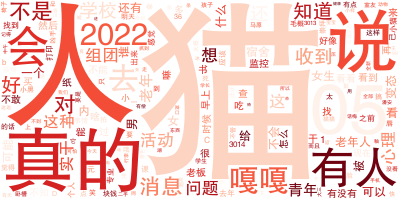

In [27]:
# 将全模式分词的结果合并成一个list
message_list = message_df.groupby("id").agg(collect_list('cut_all').alias('cut_all_list')).rdd.collect()
words = str(message_list[0]["cut_all_list"]).replace("[", "").replace("]", "").replace("'", "").split(", ")
# 统计词频
words_df = sc.parallelize(words).map(lambda x: (x, 1)).reduceByKey(add).toDF(schema=["word", "frequency"])
word_frequency = words_df.rdd.map(lambda word: (word["word"], word["frequency"])).filter(filter_dict).collect()
word_frequency_dict = {}
for i in word_frequency:
    word_frequency_dict[i[0]] = i[1]

# 生成词云
color_list = ['#FF0000', '#a41a1a']  # 建立颜色数组
colormap = colors.ListedColormap(color_list)  # 调用

wc = WordCloud(font_path="./fonts/FangZhengHeiTiJianTi-1.ttf",
               background_color='#FFFFFF', colormap=colormap, repeat=True)

wc.fit_words(word_frequency_dict)
wc.to_image()